## Text classification using Neural Networks

The goal of this notebook is to learn to use Neural Networks for text classification.

In this notebook, we will:
- Train a shallow model which learns embeddings
- Download pre-trained embeddings from Glove
- Use these pre-trained embeddings

Keep in mind:
- Deep Learning can be better on text classification that simpler ML techniques, but only on very large datasets and well designed/tuned models.
- We won't be using the most efficient (in terms of computing) techniques, as Keras is good for prototyping but rather inefficient for training small embedding models on text.
- The following projects can replicate similar word embedding models much more efficiently: [word2vec](https://github.com/dav/word2vec) and [gensim's word2vec](https://radimrehurek.com/gensim/models/word2vec.html)   (self-supervised learning only), [fastText](https://github.com/facebookresearch/fastText) (both supervised and self-supervised learning). However hard to see inside. We will use them tomorrow.
- Plain shallow sparse TF-IDF bigrams features without any embedding and Logistic Regression or Multinomial Naive Bayes is often competitive in small to medium datasets.

## The IMDB movie review dataset

(same dataset as in the TfIdf exercise.)

Fetch the dataset from http://ai.stanford.edu/~amaas/data/sentiment/ and un'tar it to
a directory near to this notebook. I placed it in `../data/`.

In [1]:
import numpy as np
from sklearn.datasets import load_files

reviews_train = load_files("../data/aclImdb/train/", categories=['neg', 'pos'])

text_trainval, y_trainval = reviews_train.data, reviews_train.target

print("type of text_train: {}".format(type(text_trainval)))
print("length of text_train: {}".format(len(text_trainval)))
print("class balance: {}".format(np.bincount(y_trainval)))

type of text_train: <class 'list'>
length of text_train: 25000
class balance: [12500 12500]


Let's randomly partition the text files in a training and test set while recording the target category of each file as an integer:

In [2]:
from sklearn.model_selection import train_test_split

# Remove some HTML and turn `bytes` into `str`
text_trainval = [doc.replace(b"<br />", b" ").decode() for doc in text_trainval]

# Use train_test_split to split up your dataset
texts_train, texts_test, target_train, target_test = train_test_split(
    text_trainval, y_trainval, stratify=y_trainval, random_state=0)

In [3]:
# look at an example review, and some other sanity checks
# just to make sure you properly loaded the data, splitting worked, etc
print("text_train[42]:\n{}".format(text_trainval[42]))

text_train[42]:
I swear I could watch this movie every weekend of my life and never get sick of it! Every aspect of human emotion is captured so magically by the acting, the script, the direction, and the general feeling of this movie. It's been a long time since I saw a movie that actually made me choke from laughter, reflect from sadness, and feel each intended feeling that comes through in this most excellent work! We need MORE MOVIES like this!!! Mike Binder: are you listening???


## A first baseline model

For simple topic classification problems, one should always try a simple method first. In this case a good baseline is extracting TF-IDF normalized bag of bi-grams features and then use a simple linear classifier such as logistic regression.

It's a very efficient method and should give us a strong baseline to compare our deep learning method against.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# create a pipeline from the TfidfVectorizer and a LogisticRegression
# fit and score the model. Make a note of the amount of CPU time.
text_classifier = make_pipeline(
    TfidfVectorizer(min_df=3, max_df=0.8, ngram_range=(1, 2)),
    LogisticRegression(),
)

In [5]:
# The %%time magic (used by itself on a single line
# at the top of a cell will measure how long the cell runs

%time _ = text_classifier.fit(texts_train, target_train)

CPU times: user 20 s, sys: 1.55 s, total: 21.6 s
Wall time: 18.3 s


In [6]:
# score your model
text_classifier.score(texts_test, target_test)

0.88495999999999997

You should reach a score of around 88%. It's unlikely that we can significantly beat this baseline with a more complex deep learning based model. However let's try to reach a comparable level of accuracy with an `Embedding`s-based model for teaching purpose.

To create a really competitive benchmark you should tune the hyper-parameters of the `TfidfVectorizer` and `LogisticRegression`. Come back to this later if you have time.

### Preprocessing text for the (supervised) CBOW model

We will implement a simple classification model in Keras. Raw text requires (sometimes a lot of) preprocessing.

The following cells uses Keras to preprocess text:
- using a tokenizer. You may use different tokenizers (from scikit-learn, spacy, custom Python function etc.). This converts the texts into sequences of indices representing the `20000` most frequent words
- sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length `1000`)
- we convert the output classes as 1-hot encodings

In [7]:
import keras
from keras.preprocessing.text import Tokenizer

MAX_NB_WORDS = 20000

# vectorize the text samples into a 2D integer tensor
# except for tuning parameters in the Tokenizer or
# using your own/different one this is mostly boilerplate
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 77916 unique tokens.


Tokenized sequences are converted to list of token ids (with an integer code):

In [8]:
sequences[0][:10]

[275, 42, 39, 84, 9, 24, 31, 1595, 1059, 4]

The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message (without formatting):

In [9]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 77916)

In [10]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [11]:
# use index_to_word to turn your sequence of integers back into text
# for one or two documents
" ".join([index_to_word[i] for i in sequences[0]])

"maybe it's just because i have an intense fear of hospitals and medical stuff but this one got under my skin pardon the pun this piece is brave not afraid to go over the top and as satisfying as they come in terms of revenge movies not only did i find myself feeling lots of hatred for the and lots of sympathy towards the i felt myself cringe and feel of disgust at certain which is really a rare and delightful thing for a somewhat jaded horror viewer like myself some parts are very of hellraiser but come off as tribute rather than imitation it's a heavy handed piece that does not offer the viewer much to consider but i enjoy being assaulted by a film once and awhile this piece brings it and doesn't i liked this one a lot do not watch whilst eating pudding"

Let's have a closer look at the tokenized sequences. The next task is dealing with the fact that each review has a different length. We will have to decide a maximum length and then convert all reviews accordingly.

In [12]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 226.4
max length: 1788


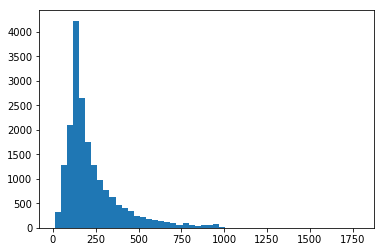

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50);

It almost looks like there was a hand made cut off at 1000, but some longer reviews got through.

Let's zoom on the distribution of regular sized reviews. The vast majority of the reviews have less than 500 symbols:

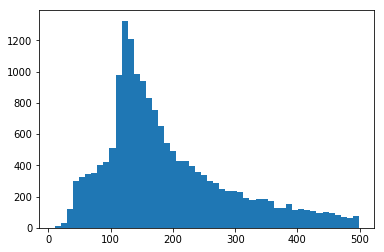

In [14]:
plt.hist([l for l in seq_lens if l < 500], bins=50);

Let's truncate and pad all the sequences to 500 symbols to build the training set.

Could you find a more quantative way to decide what sequence length to keep? Maybe look at the 95% quantile using `numpy`.

Use `pad_sequences` from `keras.preprocessing.sequence` to do the job of padding and limiting the length of our sequences

In [15]:
from keras.preprocessing.sequence import pad_sequences


MAX_SEQUENCE_LENGTH = 500

# pad sequences with 0s
X_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', X_train.shape)
print('Shape of data test tensor:', X_test.shape)

Shape of data tensor: (18750, 500)
Shape of data test tensor: (6250, 500)


In [16]:
# ew have to one hot encode our targets
from keras.utils.np_utils import to_categorical

y_train = to_categorical(target_train)
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (18750, 2)


### A simple supervised CBOW model in Keras

The following computes a very simple model, as described in [fastText](https://github.com/facebookresearch/fastText):

<img src="fasttext.svg" style="width: 600px;" />

- Build an embedding layer mapping each word to a vector representation
- Compute the vector representation (`Embedding`) of all words in each sequence and average them (`GlobalAveragePooling1D`)
  - start with an embedding size of 50
- Add a `Dense` layer to output 2 classes (+ softmax)
- connect everything together in a keras `Model`.

Once you have a working model (debug using a small dataset of 10 samples maybe), `fit` it, and score it on the test dataset.

Some more questiosn to ask yourself:
How many epochs should you use (investigate `validation_split` argument to `fit()`)? How much data do you need? What happens if you switch optimizer? How big/small can you make the embedding dimension?

In [17]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model
from keras import optimizers

EMBEDDING_DIM = 50
N_CLASSES = len(np.unique(y_train))

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.01), metrics=['acc'])

In [18]:
# fit your model on just a few epochs and small batch size (maybe 32) to make
# sure it is working, then fit on more epochs (ten or so)
model.fit(X_train, y_train, validation_split=0.1,
          epochs=2, batch_size=32)

Train on 16875 samples, validate on 1875 samples
Epoch 1/2
16875/16875 [==============================] - 10s 586us/step - loss: 0.3788 - acc: 0.8292 - val_loss: 0.3312 - val_acc: 0.8768
Epoch 2/2
16875/16875 [==============================] - 9s 561us/step - loss: 0.1754 - acc: 0.9359 - val_loss: 0.3155 - val_acc: 0.8912


Compute model accuracy on test set

In [19]:
# better, worse or the same as our baseline?
output_test = model.predict(X_test)
test_casses = np.argmax(output_test, axis=-1)
print("Test accuracy:", np.mean(test_casses == target_test))

Test accuracy: 0.8792


### Loading pre-trained embeddings

In the above exampel we learnt our own Embedding. What if we want to use some pre-made word vectors from somewhere else?

The file `glove100K.100d.txt` is an extract of the [Glove](http://nlp.stanford.edu/projects/glove/) Vectors, that were trained on english Wikipedia 2014 + Gigaword 5 (6B tokens).

It contains a subset of the `100 000` most frequent words. They have a dimension of `100`.

A compressed version of this file is in `data/` in the top level of this repository. You need to unzip it first before you can use it.

In [20]:
# what is the structure of the file?
# what are we building here?

embeddings_index = {}
embeddings_vectors = []
with open('../data/glove100K.100d.txt', 'rb') as f:
    word_idx = 0
    for line in f:
        values = line.decode('utf-8').split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = word_idx
        embeddings_vectors.append(vector)
        word_idx = word_idx + 1

inv_index = {v: k for k, v in embeddings_index.items()}
print("found %d different words in the file" % word_idx)

found 100000 different words in the file


In [21]:
# Stack all embeddings in a large numpy array
# what dimensions should that array have?
# what should be on each row?
# what should be in each column?
glove_embeddings = np.vstack(embeddings_vectors)
glove_norms = np.linalg.norm(glove_embeddings, axis=-1, keepdims=True)
glove_embeddings_normed = glove_embeddings / glove_norms


In [22]:
assert glove_embeddings.shape[1] == 100, "should have 100d for 100d vectors"

In [23]:
def get_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return None
    else:
        return glove_embeddings[idx]

    
def get_normed_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return None
    else:
        return glove_embeddings_normed[idx]

In [24]:
get_emb("computer")

array([ -1.62980005e-01,   3.01409990e-01,   5.79779983e-01,
         6.65479973e-02,   4.58350003e-01,  -1.53290004e-01,
         4.32579994e-01,  -8.92149985e-01,   5.77470005e-01,
         3.63750011e-01,   5.65240026e-01,  -5.62810004e-01,
         3.56590003e-01,  -3.60960007e-01,  -9.96619985e-02,
         5.27530015e-01,   3.88390005e-01,   9.61849988e-01,
         1.88409999e-01,   3.07410002e-01,  -8.78419995e-01,
        -3.24420005e-01,   1.12020004e+00,   7.51259997e-02,
         4.26609993e-01,  -6.06509984e-01,  -1.38929993e-01,
         4.78620008e-02,  -4.51579988e-01,   9.37229991e-02,
         1.74630001e-01,   1.09619999e+00,  -1.00440001e+00,
         6.38889968e-02,   3.80019993e-01,   2.11089998e-01,
        -6.62469983e-01,  -4.07359987e-01,   8.94420028e-01,
        -6.09740019e-01,  -1.85770005e-01,  -1.99129999e-01,
        -6.92260027e-01,  -3.18060011e-01,  -7.85650015e-01,
         2.38309994e-01,   1.29920006e-01,   8.77209976e-02,
         4.32049990e-01,

### Finding similar words

**Exercise**

Build a function to find most similar words, given a word as query:
- lookup the vector for the query word in the Glove index;
- compute the cosine similarity between a word embedding and all other words;
- display the top 10 most similar words.

**Bonus**

Change your function so that it takes multiple words as input (by averaging them)

In [25]:
def most_similar(words, topn=10):
    query_emb = 0
    # If we have a list of words instead of one word
    # (bonus question)
    if isinstance(words, list):
        for word in words:
            query_emb += get_emb(word)
    else:
        query_emb = get_emb(words)

    query_emb = query_emb / np.linalg.norm(query_emb)

    # Large numpy vector with all cosine similarities
    # between emb and all other words
    cosines = np.dot(glove_embeddings_normed, query_emb)

    # topn most similar indecies according to cosine distance
    idxs = np.argsort(cosines)[::-1][:topn]

    # pretty return with word and similarity
    return [(inv_index[idx], cosines[idx]) for idx in idxs]

In [26]:
most_similar("cpu")

[('cpu', 0.99999994),
 ('processor', 0.77934378),
 ('cpus', 0.7651844),
 ('microprocessor', 0.73606336),
 ('processors', 0.67348146),
 ('motherboard', 0.66757727),
 ('x86', 0.66559219),
 ('pentium', 0.64758503),
 ('gpu', 0.64488816),
 ('i/o', 0.63523525)]

In [26]:
most_similar("pitt")

[('pitt', 0.99999994),
 ('angelina', 0.67506438),
 ('jolie', 0.65090513),
 ('parker', 0.60754234),
 ('clooney', 0.59994197),
 ('brad', 0.59897137),
 ('thornton', 0.59552884),
 ('aniston', 0.59510386),
 ("o'donnell", 0.56095946),
 ('willis', 0.55930787)]

In [27]:
most_similar("jolie")

[('jolie', 0.99999994),
 ('angelina', 0.90007746),
 ('pitt', 0.65090501),
 ('aniston', 0.64121068),
 ('changeling', 0.61878836),
 ('neeson', 0.60497248),
 ('kidman', 0.58190113),
 ('blanchett', 0.58027673),
 ('fonda', 0.57476908),
 ('clooney', 0.56517178)]

Predict the future better than tarot:

In [28]:
np.dot(get_normed_emb('aniston'), get_normed_emb('pitt'))

0.5951038

In [29]:
np.dot(get_normed_emb('jolie'), get_normed_emb('pitt'))

0.65090507

In [30]:
most_similar("10")

[('10', 0.99999988),
 ('20', 0.97621888),
 ('15', 0.97465056),
 ('12', 0.96903414),
 ('16', 0.94835424),
 ('30', 0.94757289),
 ('13', 0.94548273),
 ('14', 0.94292229),
 ('11', 0.93357933),
 ('25', 0.93344355)]

In [31]:
most_similar("june")

[('june', 1.0),
 ('july', 0.99090481),
 ('april', 0.98993927),
 ('october', 0.98723614),
 ('february', 0.98484075),
 ('december', 0.98433733),
 ('november', 0.98312336),
 ('september', 0.98208082),
 ('january', 0.97961164),
 ('march', 0.97935444)]

In [32]:
# bonus: yangtze is a chinese river
most_similar(["river", "chinese"])

[('river', 0.819628),
 ('chinese', 0.78044909),
 ('china', 0.71793413),
 ('mainland', 0.68212998),
 ('along', 0.66073477),
 ('yangtze', 0.6465708),
 ('sea', 0.6431601),
 ('south', 0.64280045),
 ('korean', 0.64098263),
 ('southern', 0.63223374)]

### Displaying vectors with  t-SNE

100 dimensions are hard to display, let's use a popular dimensionality reduction algorithm to display them in 2D. There should be some meaning to how things are distributed.

In [33]:
from sklearn.manifold import TSNE

word_emb_tsne = TSNE(perplexity=30).fit_transform(glove_embeddings_normed[:1000])

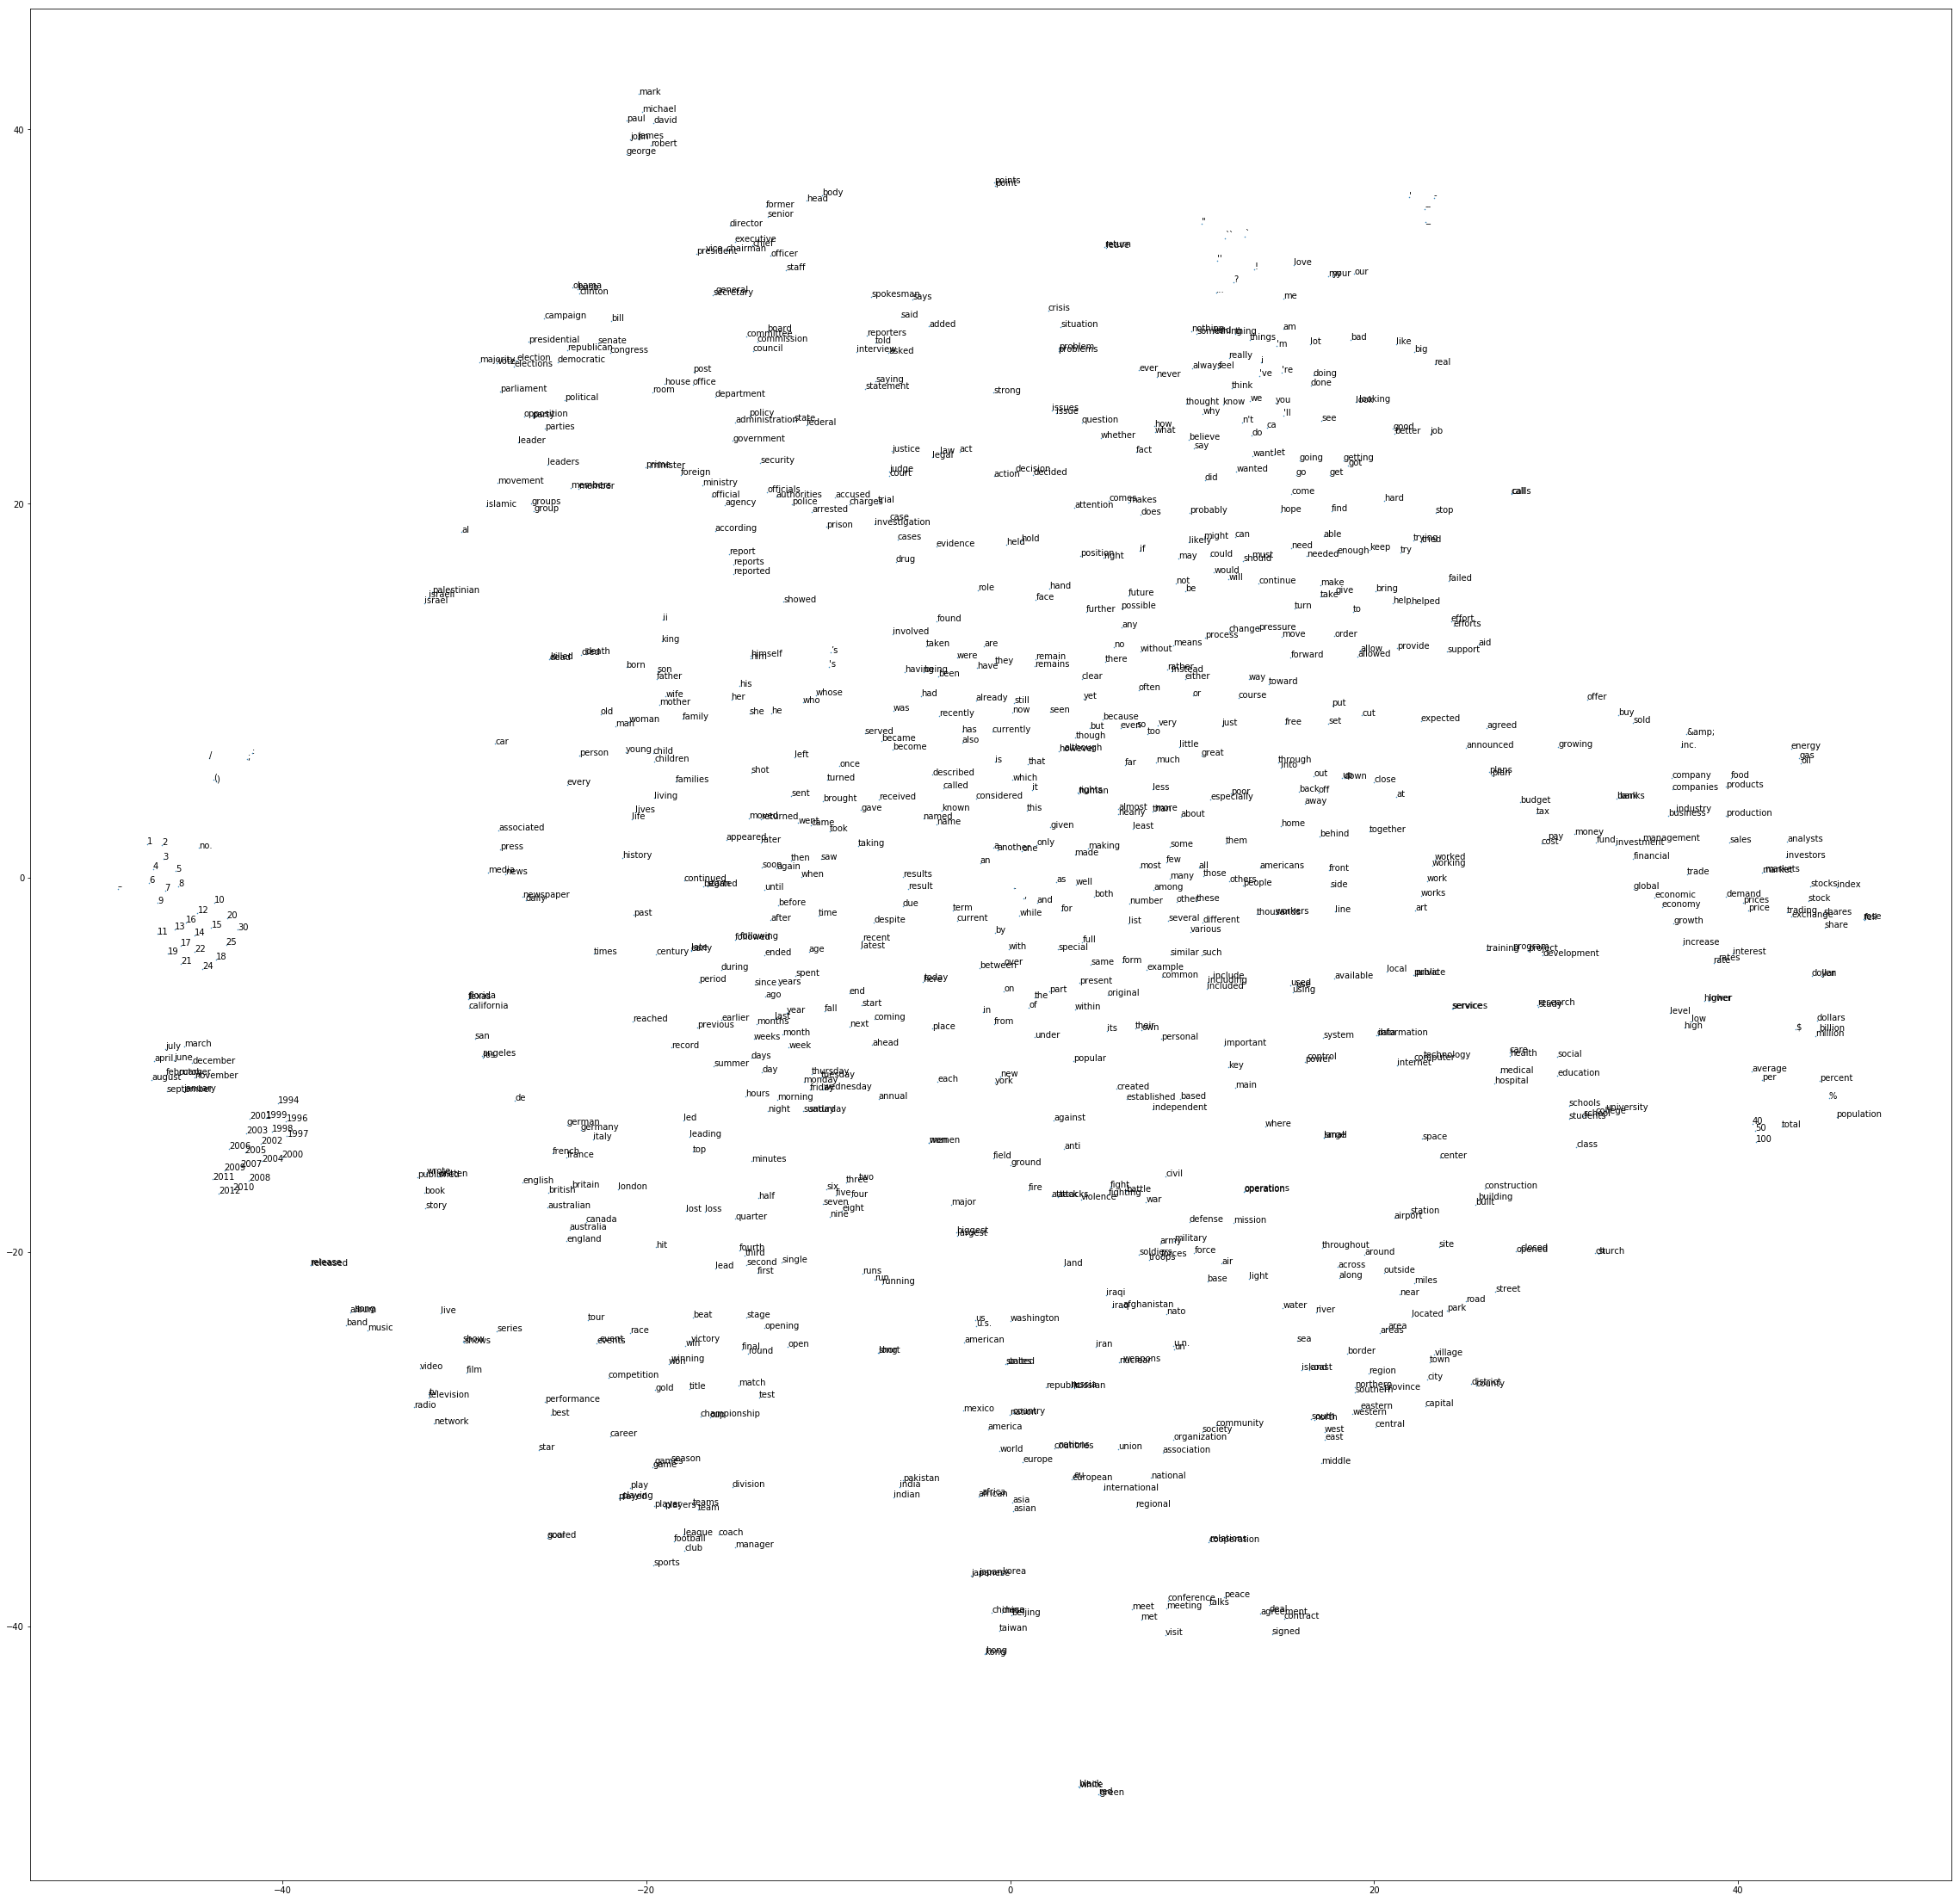

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 40))
axis = plt.gca()
np.set_printoptions(suppress=True)
plt.scatter(word_emb_tsne[:, 0], word_emb_tsne[:, 1], marker=".", s=1)

for idx in range(1000):
    plt.annotate(inv_index[idx],
                 xy=(word_emb_tsne[idx, 0], word_emb_tsne[idx, 1]),
                 xytext=(0, 0), textcoords='offset points')
plt.savefig("tsne.png")
plt.show()
# probably worth opening this in a different window so you can zoom in

### Using pre-trained embeddings in our model

We want to use these pre-trained embeddings to perform "transfer learning". This process is very similar to transfer learning in image recognition: features learned for one task are useful for other similar tasks.

The features learnt on words might help us bootstrap the learning process, and increase performance if we don't have enough training data to learn vectors ourselves.

- We initialize embedding matrix from the model with Glove embeddings:
 - take all words from our IMDB vocabulary (`MAX_NB_WORDS = 20000`), and look up their Glove embedding 
 - place the Glove embedding at the corresponding index in the matrix
 - if the word is not in the Glove vocabulary, we only place zeros in the matrix (could experiment with setting these vectors to random values or amybe lookup most similar word and use the embedding for that?)
- We may fix these embeddings or fine-tune them

There is an example in ther keras documentation which is similar to what we will do: https://github.com/keras-team/keras/blob/454be50414967002197cc40be9d968a16a07f6b9/examples/pretrained_word_embeddings.py#L103-L121

In [35]:
EMBEDDING_DIM = 100

# prepare embedding matrix
nb_words_in_matrix = 0
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = get_emb(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        nb_words_in_matrix = nb_words_in_matrix + 1
        
print("added %d words in the embedding matrix" % nb_words_in_matrix)

added 18412 words in the embedding matrix


Build a layer with pre-trained embeddings:

In [36]:
pretrained_embedding_layer = Embedding(
    MAX_NB_WORDS, EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
)

### A model with pre-trained Embeddings

Averaging word embeddings pre-trained with Glove / Word2Vec usually works surprisingly well. However, when averaging more than `10-15` words, the resulting vector becomes too noisy and classification performance is degraded.

In [37]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = pretrained_embedding_layer(sequence_input)
average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)

# We don't want to fine-tune the embeddings
model.layers[1].trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.01), metrics=['acc'])

In [38]:
model.fit(X_train, y_train, validation_split=0.1,
          epochs=15, batch_size=32)

Train on 16875 samples, validate on 1875 samples
Epoch 1/15
16875/16875 [==============================] - 2s 148us/step - loss: 0.6165 - acc: 0.6824 - val_loss: 0.5897 - val_acc: 0.7083
Epoch 2/15
16875/16875 [==============================] - 2s 142us/step - loss: 0.5568 - acc: 0.7423 - val_loss: 0.5604 - val_acc: 0.7499
Epoch 3/15
16875/16875 [==============================] - 2s 136us/step - loss: 0.5335 - acc: 0.7592 - val_loss: 0.5623 - val_acc: 0.7296
Epoch 4/15
16875/16875 [==============================] - 2s 134us/step - loss: 0.5180 - acc: 0.7658 - val_loss: 0.5538 - val_acc: 0.7397
Epoch 5/15
16875/16875 [==============================] - 2s 134us/step - loss: 0.5084 - acc: 0.7713 - val_loss: 0.5399 - val_acc: 0.7504
Epoch 6/15
16875/16875 [==============================] - 2s 142us/step - loss: 0.5022 - acc: 0.7745 - val_loss: 0.5255 - val_acc: 0.7621
Epoch 7/15
16875/16875 [==============================] - 2s 136us/step - loss: 0.4947 - acc: 0.7773 - val_loss: 0.5156 - v

**Remarks:**

- On this type of task, using pre-trained embeddings can degrade results as we train much less parameters and we average a large number pre-trained embeddings. Check out `model.summary()` to see how many trainable parameters your keras model has. Compare between the one that uses pre-trained vectors and the one that learns vectors.

- Pre-trained embeddings followed by global averaging prevents overfitting but can also cause some underfitting.

Pre-trained embeddings can be very useful when the training set is small and the individual text documents to classify are short: in this case there might be a single very important word in the test document that drives the label. If that word has never been seen in the training set but some synonyms were seen, the semantic similarity captured by the embedding will allow the model to generalized out of the restricted training set vocabulary.

We did not observe this effect here because the document are long enough so that guessing the topic can be done redundantly. Shortening the documents to make the task more difficult could possibly highlight this benefit. Investigate this!

## What about other languages?

If you have time find a dataset in German and use the word vectors from https://fasttext.cc/docs/en/crawl-vectors.html to build a similar model for texts in languages other than English.

## Reality check

On small/medium datasets (this one is small), simpler classification methods usually perform better, and are much more efficient to compute. Here are two resources to go further:
- Naive Bayes approach, using scikit-learn http://scikit-learn.org/stable/datasets/twenty_newsgroups.html
- Alec Radford (OpenAI) gave a very interesting presentation, showing that you need a VERY large dataset to have real gains from GRU/LSTM in text classification https://www.slideshare.net/odsc/alec-radfordodsc-presentation

However, when looking at the features used by simple lienar models one can see that classification is probably not very robust, and won't generalize well to slightly different domains (e.g. forum posts => emails). Try this out by feeding movie reviews from the internet to your models. For example from [Rotten Tomatoes](https://www.rottentomatoes.com/)

Note: Implementations in Keras for text is very slow due to python overhead and lack of hashing techniques. `fastText` implementation https://github.com/facebookresearch/fasttext is much, much faster. Use this in production!

## Going further

- Compare pre-trained embeddings vs specifically trained embeddings
- Check [Keras Examples](https://github.com/fchollet/keras/tree/master/examples) on `imdb` sentiment analysis

- Today, the **state-of-the-art text classification** can be achieved by **transfer learning from a language model** instead of using traditional word embeddings. See for instance: FitLaM, Fine-tuned Language Models for Text Classification https://arxiv.org/abs/1801.06146. Or even more recently: https://blog.openai.com/language-unsupervised/
- Interesting to read and try out https://github.com/facebookresearch/InferSent Deals with the problem of embedding sentences instead of averaging words.